<b><font size=20, color='#A020F0'>Final Project</font></b>

#### Analysis of MERRA-2 data for Saharan Dust Storm "Godzilla" on June 25th 2020

Aerosols such as Saharan dust are known to impact the thermodynamics of the atmosphere through their radiative properties by absorbing and scattering solar radiation and thus inducing heating or cooling. Additionally, the Saharan Air Layer (SAL), a layer of air that forms over the Sahara Desert that can be advected over the Atlantic is known to introduce dry dusty air into the tropical Atlantic Ocean and has been linked to the suppresion of tropical cyclones [(Dunion et al., 2004)](https://journals.ametsoc.org/view/journals/bams/85/3/bams-85-3-353.xml). However, the accurate representation of such aerosols in numerical weather prediction (NWP) models remains limited, particularly because of a lack of precision in the vertical distribution of aerosols in the atmophere. Because aerosols are not well characterized in NWP models, data from such regions are often rejected in model calculations due to large discrepancies with observations. There is therefore a need for greater understanding of the impact of aerosols on the thermodynamics of the atmosphere. In this project, we seek to further understand the impact of the vertical distribution of aerosols on the atmosphere by analysing a case where aerosol concentration in the tropical Atlantic Ocean was at a historical high. This storm, nicknamed the "Godzilla" dust storm, happened in June 2020. During this storm, two large dust plumes were transported off the coast of Northwest Africa all the way into the Carribean Basin. You can read more about this event [here](https://acp.copernicus.org/articles/21/12359/2021/acp-21-12359-2021.pdf) and watch an animation of it [here](https://svs.gsfc.nasa.gov/4849).

In [1]:
#Import relavant packages
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import metpy.calc as mpcalc
from metpy.units import units
import metpy.plots as mplots
from PIL import Image
import glob

In [2]:
#Read in data
ds = xr.open_dataset('DUMR_data.nc4')
ds2 = xr.open_dataset('RH_T_data.nc4')

Let's take a look at what's in the two datasets:

In [3]:
ds

<xarray.Dataset>
Dimensions:  (lon: 576, lat: 361, lev: 72, time: 8)
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 68.0 69.0 70.0 71.0 72.0
  * time     (time) datetime64[ns] 2020-06-25 ... 2020-06-25T21:00:00
Data variables:
    DELP     (lev, lat, lon) float32 ...
    DUMR     (lev, lat, lon) float32 ...
Attributes: (12/30)
    History:                           Original file generated: Sun Jul  5 20...
    Comment:                           GMAO filename: d5124_m2_jan10.inst3_3d...
    Filename:                          MERRA2_400.inst3_3d_aer_Nv.20200625.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/LTVB4GPCOTK2
    RangeBeginningDate:                2020-06-25
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2020-06-25
    RangeEndingTime:                   21:00:00.000000

This dataset gives us a total dust mixing ratio (DUMR) as well as the variable DELP which we will address shortly.

In [4]:
ds2

<xarray.Dataset>
Dimensions:  (lon: 576, lat: 361, lev: 72)
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 68.0 69.0 70.0 71.0 72.0
Data variables:
    DELP     (lev, lat, lon) float32 ...
    T        (lev, lat, lon) float32 ...
    U        (lev, lat, lon) float32 ...
    V        (lev, lat, lon) float32 ...
    QV       (lev, lat, lon) float32 ...

This dataset gives us temperture (T), zonal wind (U), meridional wind (V) and specific humidity (QV).

The coordinates for each dataset are latitude, longitude and level. The data in these two datasets were collected at 72 different pressure levels. We will need to create a pressure variable from 'DELP' for both datasets, which is the change in pressure at each level. For this, we simply need to add the value of DELP at each level to the sum of the previous values, starting at the top of the atmosphere. We will also convert the temperature variable to degrees Celcius.

In [5]:
ds2['T'] = (ds2['T'] - 273.15) # convert temperature to degrees Celcius

# Calculate pressure from DELP variable for first dataset
ds['pres']= ds.DELP
for i in range(1,72):
    dp =  ds.pres[i]
    ds['pres'][i] = dp + ds['pres'][i-1]
ds['pres']=ds['pres']/100 #convert to hPa

# Calculate pressure from DELP variable for second dataset
ds2['pres']= ds2.DELP
for i in range(1,72):
    dp =  ds2.pres[i]
    ds2['pres'][i] = dp + ds2['pres'][i-1]
ds2['pres']=ds2['pres']/100 #convert to hPa

Now both of our datasets have a pressure variable, increasing from low to high:

In [6]:
ds.pres

<xarray.DataArray 'pres' (lev: 72, lat: 361, lon: 576)>
array([[[1.00000016e-02, 1.00000016e-02, 1.00000016e-02, ...,
         1.00000016e-02, 1.00000016e-02, 1.00000016e-02],
        [1.00000016e-02, 1.00000016e-02, 1.00000016e-02, ...,
         1.00000016e-02, 1.00000016e-02, 1.00000016e-02],
        [1.00000016e-02, 1.00000016e-02, 1.00000016e-02, ...,
         1.00000016e-02, 1.00000016e-02, 1.00000016e-02],
        ...,
        [1.00000016e-02, 1.00000016e-02, 1.00000016e-02, ...,
         1.00000016e-02, 1.00000016e-02, 1.00000016e-02],
        [1.00000016e-02, 1.00000016e-02, 1.00000016e-02, ...,
         1.00000016e-02, 1.00000016e-02, 1.00000016e-02],
        [1.00000016e-02, 1.00000016e-02, 1.00000016e-02, ...,
         1.00000016e-02, 1.00000016e-02, 1.00000016e-02]],

       [[2.27000043e-02, 2.27000043e-02, 2.27000043e-02, ...,
         2.27000043e-02, 2.27000043e-02, 2.27000043e-02],
        [2.27000043e-02, 2.27000043e-02, 2.27000043e-02, ...,
         2.27000043e-02, 2.27000043e-02, 2.27000043e-02],
        [2.27000043e-02, 2.27000043e-02, 2.27000043e-02, ...,
         2.27000043e-02, 2.27000043e-02, 2.27000043e-02],
...
        [9.96543152e+02, 9.96543152e+02, 9.96543152e+02, ...,
         9.96543152e+02, 9.96543152e+02, 9.96543152e+02],
        [9.96735779e+02, 9.96737183e+02, 9.96737183e+02, ...,
         9.96721252e+02, 9.96721252e+02, 9.96721252e+02],
        [9.96825134e+02, 9.96825134e+02, 9.96825134e+02, ...,
         9.96825134e+02, 9.96825134e+02, 9.96825134e+02]],

       [[6.83904114e+02, 6.83904114e+02, 6.83904114e+02, ...,
         6.83904114e+02, 6.83904114e+02, 6.83904114e+02],
        [6.77702393e+02, 6.78156616e+02, 6.78156616e+02, ...,
         6.76945679e+02, 6.76945679e+02, 6.76945679e+02],
        [6.66744385e+02, 6.66744385e+02, 6.66744385e+02, ...,
         6.66744385e+02, 6.66744385e+02, 6.66744385e+02],
        ...,
        [1.01171967e+03, 1.01171967e+03, 1.01171967e+03, ...,
         1.01171967e+03, 1.01171967e+03, 1.01171967e+03],
        [1.01191528e+03, 1.01191675e+03, 1.01191675e+03, ...,
         1.01190045e+03, 1.01190045e+03, 1.01190045e+03],
        [1.01200580e+03, 1.01200580e+03, 1.01200580e+03, ...,
         1.01200580e+03, 1.01200580e+03, 1.01200580e+03]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 68.0 69.0 70.0 71.0 72.0

In [7]:
ds2.pres

<xarray.DataArray 'pres' (lev: 72, lat: 361, lon: 576)>
array([[[1.00000026e-02, 1.00000026e-02, 1.00000026e-02, ...,
         1.00000026e-02, 1.00000026e-02, 1.00000026e-02],
        [1.00000026e-02, 1.00000026e-02, 1.00000026e-02, ...,
         1.00000026e-02, 1.00000026e-02, 1.00000026e-02],
        [1.00000026e-02, 1.00000026e-02, 1.00000026e-02, ...,
         1.00000026e-02, 1.00000026e-02, 1.00000026e-02],
        ...,
        [1.00000026e-02, 1.00000026e-02, 1.00000026e-02, ...,
         1.00000026e-02, 1.00000026e-02, 1.00000026e-02],
        [1.00000026e-02, 1.00000026e-02, 1.00000026e-02, ...,
         1.00000026e-02, 1.00000026e-02, 1.00000026e-02],
        [1.00000026e-02, 1.00000026e-02, 1.00000026e-02, ...,
         1.00000026e-02, 1.00000026e-02, 1.00000026e-02]],

       [[2.27000043e-02, 2.27000043e-02, 2.27000043e-02, ...,
         2.27000043e-02, 2.27000043e-02, 2.27000043e-02],
        [2.27000043e-02, 2.27000043e-02, 2.27000043e-02, ...,
         2.27000043e-02, 2.27000043e-02, 2.27000043e-02],
        [2.27000043e-02, 2.27000043e-02, 2.27000043e-02, ...,
         2.27000043e-02, 2.27000043e-02, 2.27000043e-02],
...
        [9.96402893e+02, 9.96397949e+02, 9.96392639e+02, ...,
         9.96419006e+02, 9.96413513e+02, 9.96408264e+02],
        [9.96660217e+02, 9.96657715e+02, 9.96655212e+02, ...,
         9.96667908e+02, 9.96665222e+02, 9.96662659e+02],
        [9.96757507e+02, 9.96757507e+02, 9.96757507e+02, ...,
         9.96757507e+02, 9.96757507e+02, 9.96757507e+02]],

       [[6.83817993e+02, 6.83817993e+02, 6.83817993e+02, ...,
         6.83817993e+02, 6.83817993e+02, 6.83817993e+02],
        [6.76705933e+02, 6.76777405e+02, 6.76849915e+02, ...,
         6.76499695e+02, 6.76567139e+02, 6.76635986e+02],
        [6.66182434e+02, 6.66286377e+02, 6.66393494e+02, ...,
         6.65889526e+02, 6.65984009e+02, 6.66081665e+02],
        ...,
        [1.01157727e+03, 1.01157227e+03, 1.01156689e+03, ...,
         1.01159357e+03, 1.01158807e+03, 1.01158276e+03],
        [1.01183850e+03, 1.01183594e+03, 1.01183344e+03, ...,
         1.01184625e+03, 1.01184357e+03, 1.01184094e+03],
        [1.01193726e+03, 1.01193726e+03, 1.01193726e+03, ...,
         1.01193726e+03, 1.01193726e+03, 1.01193726e+03]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lev      (lev) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 68.0 69.0 70.0 71.0 72.0

#### Global Dust Concentration Plot

If you watched the animation, you will have seen that the event lasted throughout the month of June. For this project, we will analyze data from June 25th, when the second dust plume was right over the Atlantic. To visualize the dust storm on this day, we can plot the total dust mixing ratio (DUMR) over latitude and longitude:

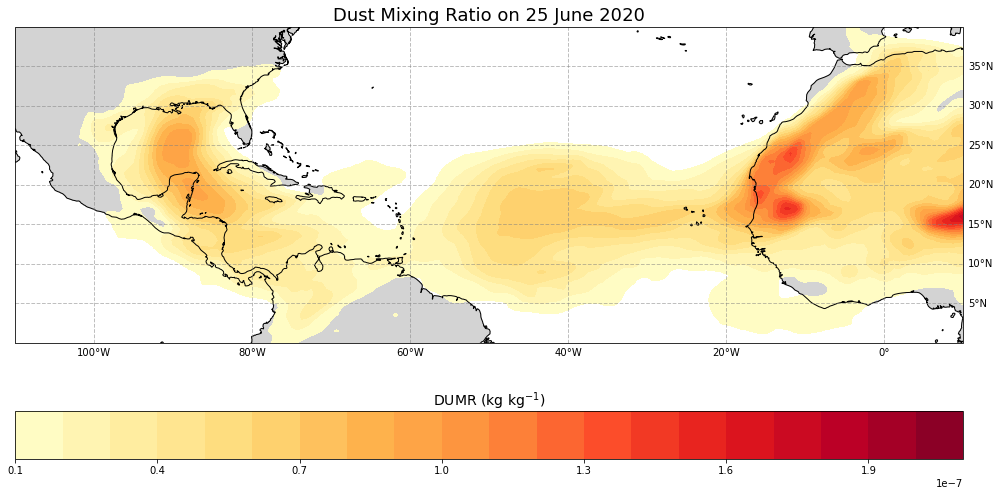

In [8]:
# Take mean DUMR over height to create a 2D variable 
ds['avg_dumr'] = ds.DUMR.mean('lev') 

# Define a function so we can reuse this plot later
def plot_dust():
    """ Plot dust mixing ratio over the Atlantic on 25 June 2020 """
    
    # Plot dust
    fig=plt.figure(figsize=(14,7))
    fig.set_tight_layout(True)
    ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
    ax.coastlines(color='k')
    ax.set_extent([-110, 10, 0, 40], crs=ccrs.PlateCarree()) #set lat lon bounds
    ax.add_feature(cfeature.LAND,color='lightgray') 
    dust_range= np.arange(10e-9,22e-8,10e-9) # limit plotted values of DUMR to this range
    cs=ax.contourf(ds.lon,ds.lat,ds.avg_dumr,transform=ccrs.PlateCarree(),cmap=plt.cm.YlOrRd,levels=dust_range)
    ax.set_title('Dust Mixing Ratio on 25 June 2020',fontsize=18)

    # Create colorbar
    cbar=plt.colorbar(cs,orientation='horizontal')
    cbar.ax.set_title('DUMR (kg kg$^{-1}$)',fontsize=14) 

    # Create gridlines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.left_labels = False
    gl.locator = mticker.FixedLocator([-105, -90, -75, -60, -45, -30, -15, 0, 15])
    
plot_dust()

This gives us an idea of how the dust was spatially distributed on June 25th, 2020. We can see that the first plume is already in the Carribean Basin, and the second plume is right over the middle of the tropical Atlantic Ocean. However, this plot gives us no information on the vertical distribution of dust. We'll look into that in the next section. But first, because this event happened over several days, it would be insightful to see the evolution of DUMR over the course of this storm. To do this, we would need to generate plots for different datasets corresponding to different days, but for the sake of storage space, I have generated these plots on my own using the same code as above (minus the latitude and longitude gridlines). The plots are found in the duust_plots folder. We can use these plots to create an animation from June 10th to June 26th.

_Note to grader: This code takes a few minutes to run, so feel free to come back to this later. I also left this part commented out because there seems to be something weird happening to the GIF when it's created, with some blank patches showing up on some of the plots._

In [9]:
# # Create a frame for each plot
# frames = []

# # Add each frame to an array of images
# for i in range(10,27):
#     new_frame = Image.open('dust_plots/merra_dust_godzilla_202006%s.png' %(i)) 
#     frames.append(new_frame)

# # Save images into a GIF file
# frames[0].save('DUMR_June2020.gif', format='GIF', append_images=frames[1:], optimize=False, save_all=True, duration=40)#, loop=0) 

#### Creating Thermodynamic Profiles

The core part of our analysis consists in analyzing the impact of dust on the thermodynamics of the atmosphere. For this, we will create thermodynamic profiles comparing dust mixing ratio (DUMR) and relative humidity (RH), with a temperature profile also plotted. We will need to manipulate the data a little since we are given specfic humidity but not relative humidity. As we can see from the previous plot, this event impacted a large region of the Earth's atmosphere, and thus the effects are likely to be different in different locations. For this reason, we need a code that lets us generate profiles over a wide range of latitudes and longitudes so that we can see the impacts of this storm at different locations. Here we will plot profiles between 10°N and 20°N and 60°W and 20°W. Take a look at the previous plot so see what region that corresponds to.

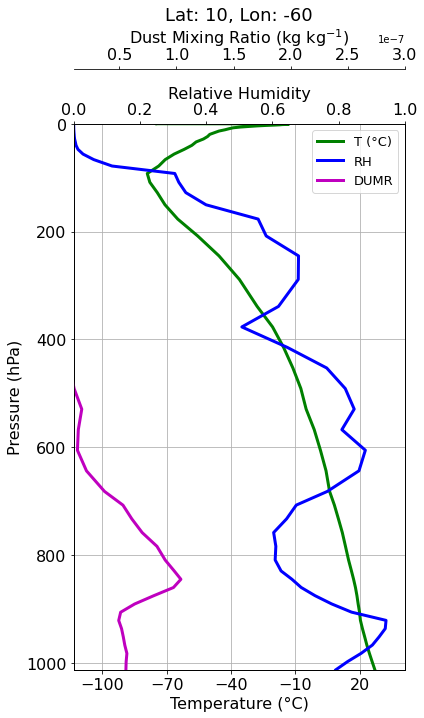

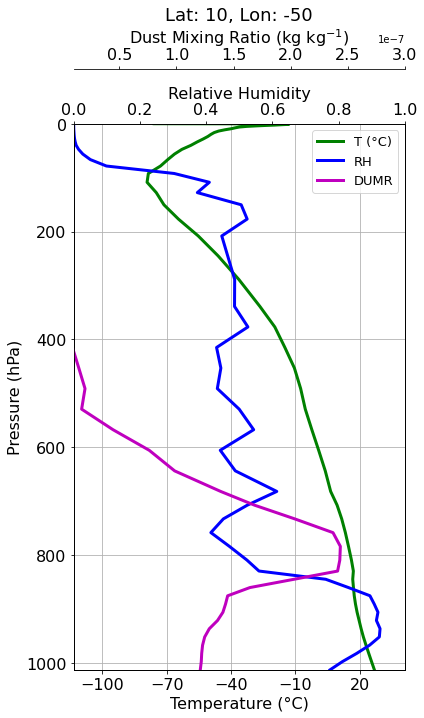

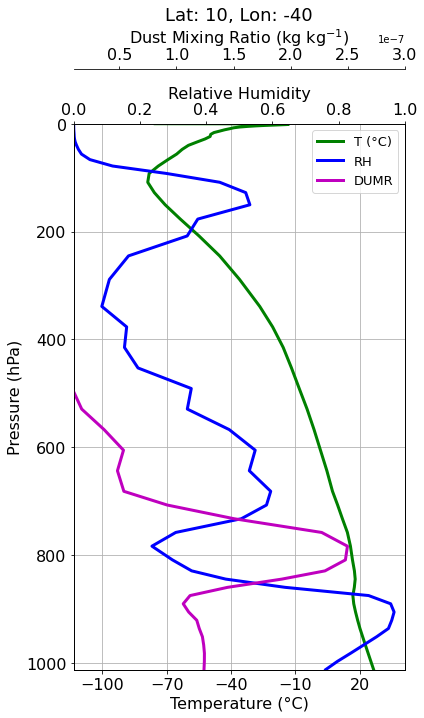

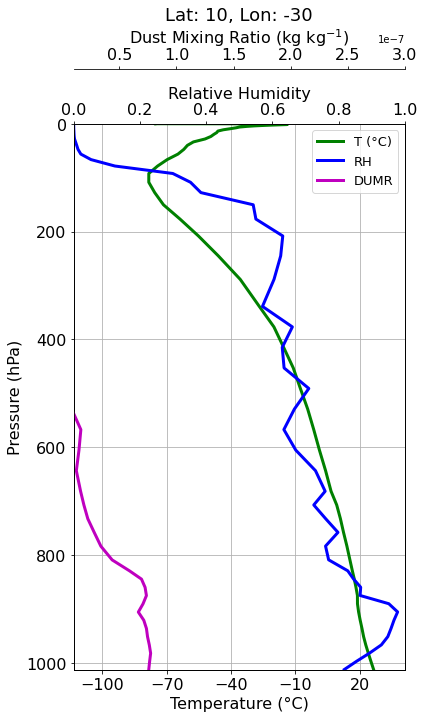

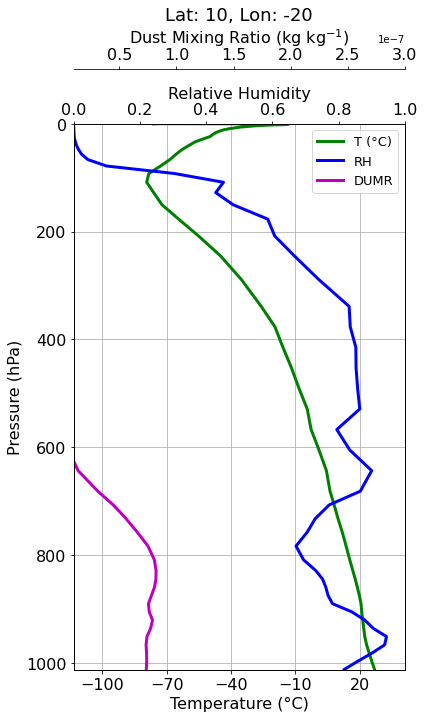

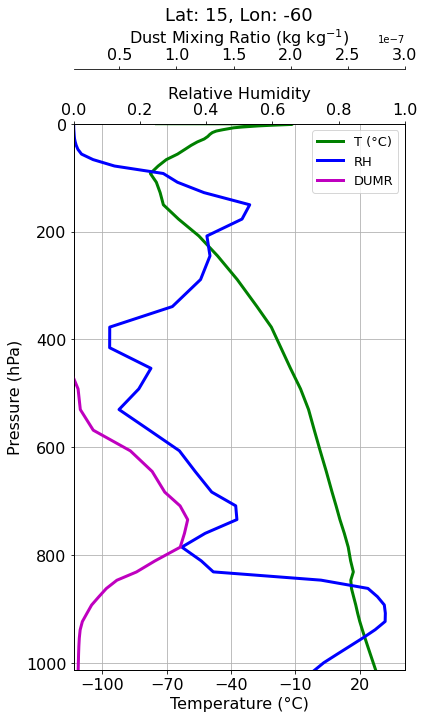

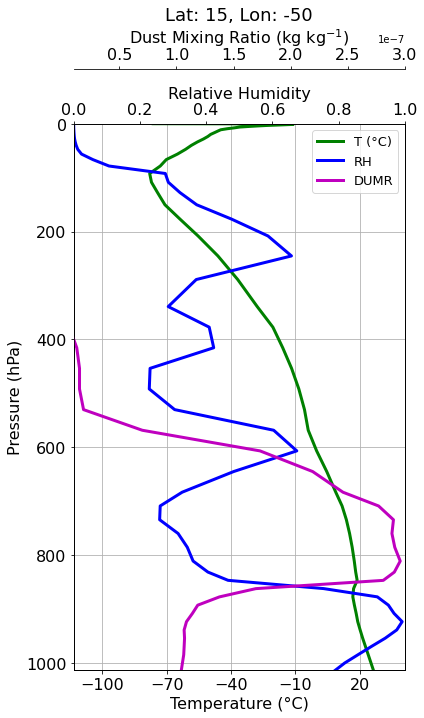

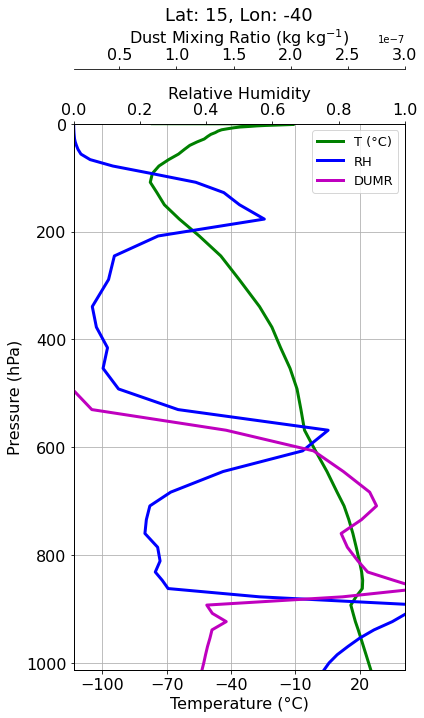

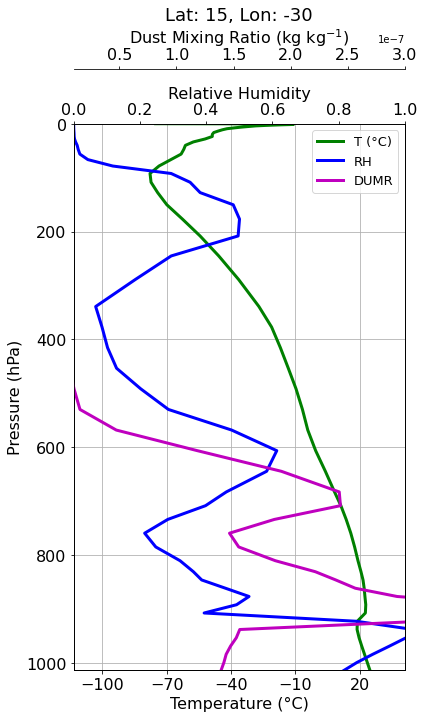

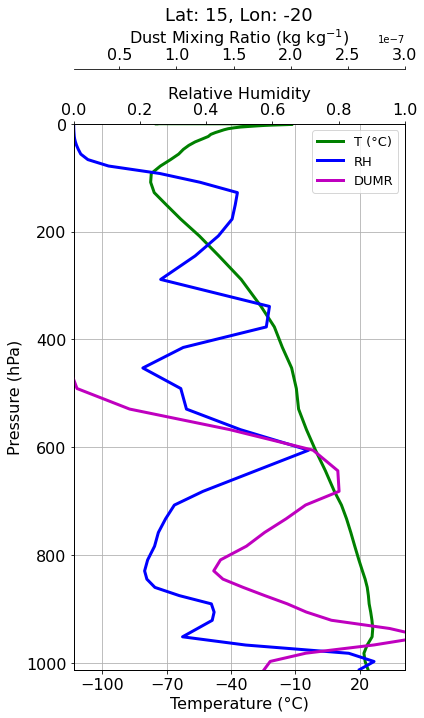

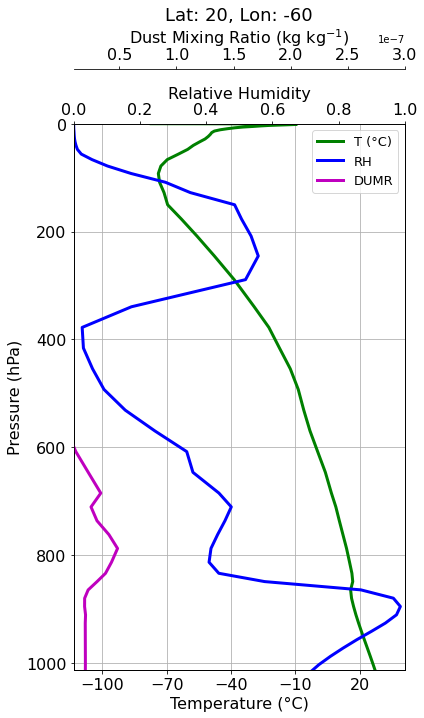

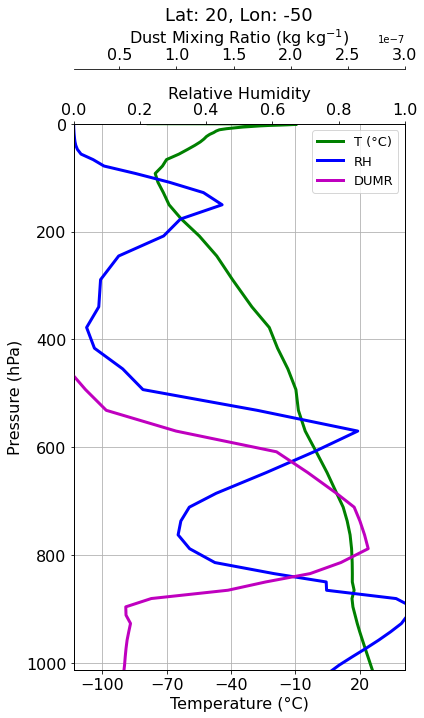

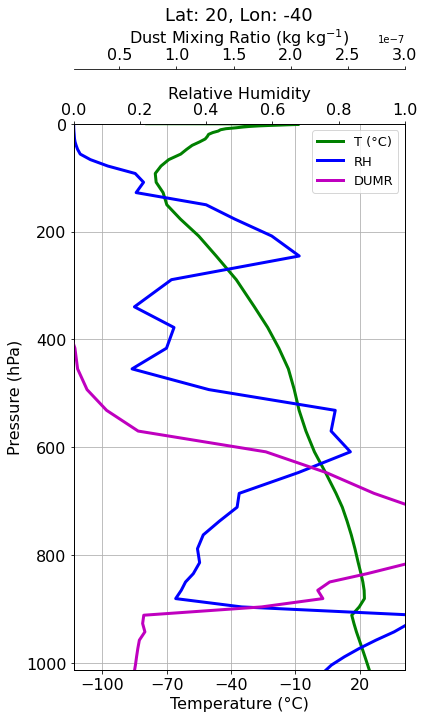

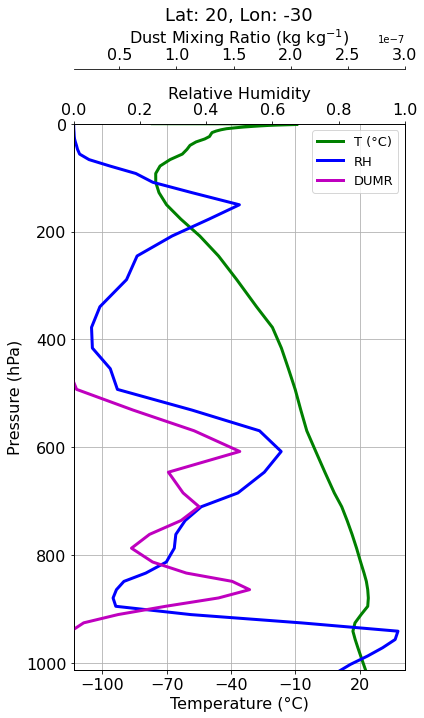

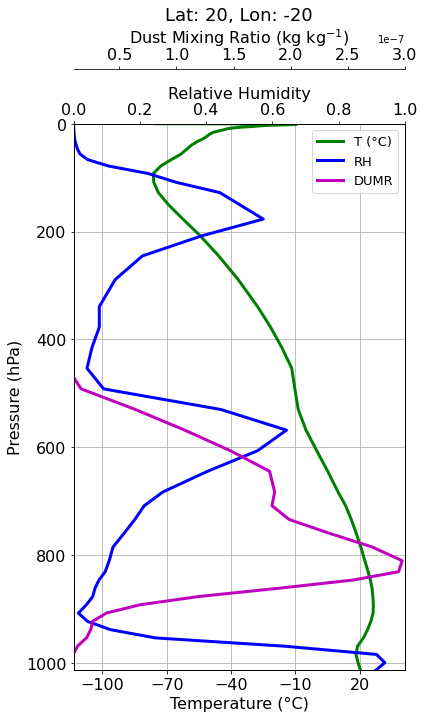

In [10]:
# Plot dust, temperature and relative humidity for range of latitudes and longitude (can be edited to create plots at locations of interest)
for i in range (10, 25, 5): # plot profiles between latitudes 10°N and 20°N
    latitude = i
    
    for j in range(-60, -10, 10): # plot profiles from longitudes 60°W and 20°W
        longitude = j

        fig, ax = plt.subplots(figsize=(6,10))   
        plt.subplots_adjust(top=0.8)
        fig.set_tight_layout(True)
        twin = ax.twiny() #create two twin axes for plotting RH and DUMR on top of temperature
        twin2 = ax.twiny()
        twin2.spines.top.set_position(("axes", 1.1))
        
        # Select profile at specified longitude and latitude
        dumr = ds.DUMR.sel(lat = latitude,lon = longitude)
        pres = ds.pres.sel(lat = latitude,lon = longitude)
        pres2 = ds2.pres.sel(lat = latitude,lon = longitude)
        temp = ds2.T.sel(lat = latitude,lon = longitude)
        QV = ds2.QV.sel(lat = latitude,lon = longitude)
        
        # Calculate relative humidity from specific humidity
        pressure = pres2.values * units.hPa
        temperature = temp.values * units.degC
        specific_humidity = QV.values * units('kg/kg')
        RH = mpcalc.relative_humidity_from_specific_humidity(pressure, temperature, specific_humidity)
    
        # Plot profiles, creating two extra x-axes
        p1, = ax.plot(temp, pres2,'g',lw=3, label = 'T (°C)')
        p2, = twin.plot(RH.magnitude, pres2,'b',lw=3, label = 'RH')
        p3, = twin2.plot(dumr, pres,'m',lw=3, label = 'DUMR')
    
        # Set limits
        ax.set_ylim([1013,0])
        ax.set_xlim([np.min(ds2.T),np.max(ds2.T)])
        # Set range on x-axis so all plots are on the same scale
        twin.set_xlim([0.0,1.0])
        twin2.set_xlim([10e-9,30e-8]) 

        # Set labels
        ax.set_ylabel('Pressure (hPa)',fontsize = 16)
        ax.set_xlabel('Temperature (°C)',fontsize = 16)
        twin.set_xlabel('Relative Humidity',fontsize = 16)
        twin2.set_xlabel('Dust Mixing Ratio (kg kg$^{-1}$)',fontsize = 16)
    
        # Set ticks
        ax.xaxis.set_ticks(np.arange(-100, 50, 30)) # select values for temperature ticks (default gives too few ticks)
        ax.tick_params(axis='both', which='major', labelsize=16)
        twin.tick_params(axis='x', which='major', labelsize=16)
        twin2.tick_params(axis='x', which='major', labelsize=16)
        
        # Add titles legend and grid
        plt.title('Lat: %s, Lon: %s' % (latitude,longitude), fontsize = 18) 
        ax.legend(handles=[p1, p2, p3],fontsize=13)
        ax.grid()
        #twin.grid() #these lines can be uncommented for the grid to align with the different x-axes
        #twin2.grid()
        
        plt.show() 

Wow! There's a lot going on here, so let's try to unpack it. The first thing we can see is that the dust is located mainly between 850hPa and 650hPa. This is typical for a Saharan dust storm. Around this region, we can see that generally, wherever DUMR is high, RH is low. This confirms our suspicion that the presence of dust genrally has a drying effect on the atmosphere. However, we need to keep in mind that these plots give us a snapshot of what's happening at one location and point in time, but the event lasted for several days. The drying effect of dust on the atmosphere is not instantaneous, so some plots may have low DUMR and also low RH, but this doesn't mean that dust is not responsible for drying the atmosphere in those locations, as dust can affect an area and then be advected away, leaving a dryer atmosphere behind it. From these plots, we can see that the temperature of the atmosphere is pretty constant throughout the region in question, but a slight inversion can be seen  for many of the locations with high DUMR around 850hPa or 900hPa. This shows that the warming effect of aerosols has the strongest imapct at the bottom of the dust plume. Finally, you might notice that some of the relative humidities slightly surpass 100%. This is likely to be caused by metpy’s relative_humidity_from_specific_humidity function, where errors may be introduced in rounding (another cause might also be errors introduced during data collection).

From these plots, we get an idea of the vertical distribution of dust in the atmosphere. The majority of it seems to be contained between 650hPa and 850hPa. You may be wondering how exactly the dust was transported along the path that it was, so let's take a look at the wind at those pressure levels. Our vertical coordinate is expressed as a level (rather than a pressure or altitude), so first let's print out the value for pressure at some of these levels. Of course, the pressure is not constant at each level, so we'll take an average of the pressure throughout the level for each level that we're looking at.

In [11]:
print(ds2.pres.sel(lev=54).mean(axis=0).mean(axis=0).values)
print(ds2.pres.sel(lev=55).mean(axis=0).mean(axis=0).values)
print(ds2.pres.sel(lev=56).mean(axis=0).mean(axis=0).values)
print(ds2.pres.sel(lev=57).mean(axis=0).mean(axis=0).values)
print(ds2.pres.sel(lev=58).mean(axis=0).mean(axis=0).values)
print(ds2.pres.sel(lev=59).mean(axis=0).mean(axis=0).values)
print(ds2.pres.sel(lev=60).mean(axis=0).mean(axis=0).values)
print(ds2.pres.sel(lev=61).mean(axis=0).mean(axis=0).values)
print(ds2.pres.sel(lev=62).mean(axis=0).mean(axis=0).values)
print(ds2.pres.sel(lev=63).mean(axis=0).mean(axis=0).values)
print(ds2.pres.sel(lev=64).mean(axis=0).mean(axis=0).values)

656.9173
680.7682
704.6176
728.4659
752.29895
776.13257
795.19934
809.4959
823.7909
838.0844
852.37775


From this, we can see that the majority of the dust is located between levels 54 and 64.

#### Plotting Wind Vectors

Now that we know which levels correspond to the location of the dust, we can look into how wind affects dust transport. For this, we'll take a look at the wind velocity vectors by extracting the wind vectors at the pressure levels where the dust is located, and then calculating the magnitude of the zonal and meridional winds. Then we will plot u and v as unit vectors.

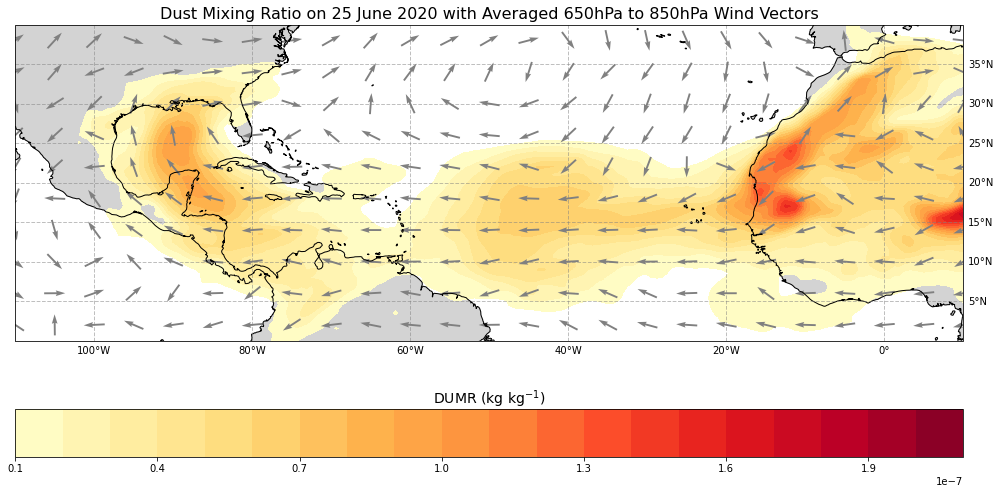

In [12]:
# Plot original dust plot again
plot_dust()

# Add wind vectors
u = ds2.U.sel(lev=(54,55,56,57,58,59,60,61,62,63,64)).mean('lev') # take the mean zonal velocity between 650 and 850hPa
v = ds2.V.sel(lev=(54,55,56,57,58,59,60,61,62,63,64)).mean('lev') # take the mean meridional velocity between 650 and 850hPa
mag = np.sqrt(u**2 + v**2) # calculate magnitude
u_vec = u/mag #create unit vector
v_vec = v/mag #create unit vector
x,y=np.meshgrid(mag.lon,mag.lat)
space = 8
plt.quiver(x[::space,::space],y[::space,::space],u_vec[::space,::space].values,v_vec[::space,::space].values,transform=ccrs.PlateCarree(),pivot='middle',color='gray',scale=45,width=.0020,headwidth=3);
plt.title("Dust Mixing Ratio on 25 June 2020 with Averaged 650hPa to 850hPa Wind Vectors",fontsize=16);

This storm was originally pushed off of the coast of northwest Africa by a strong African Easterly Jet, which we can see as a slightly wavy pattern on the West African coast. The wind across the Atlantic seems almost purely zonal. We can also see an anticyclonic circulation pattern in the North Atlantic subtropics which seems to be constraining the dust to the tropics. Finally, in the Carribean Basin, we can see the dust being advected northward towards the southern United States. If you're interested in the dynamics of how this storm was originally generated, you can read more about it in the [Yu et al., 2021](https://acp.copernicus.org/articles/21/12359/2021/acp-21-12359-2021.pdf) paper I linked ealier.

#### Creating a Skew-T diagram

Finally, we are interested in the impact of Saharan dust on the formation of tropical cyclones. From our data, we can look at how dust impacts convection in the atmosphere. In this final part, we'll use metpy to calculate CAPE and CIN for 2 different locations. For this example, we'll pick one location with high DUMR, and one with low DUMR (at 15°N, 50°W and 10°, 30°W respectively), making sure these are not profiles where RH exceeds 100%.

During this section, I ran into some issues with calculating the parcel profile, where the dimesions in one of the calculations that metpy's parcel_profile function does under the hood did not seem to match up. The issue was likely caused by the fact that the dewpoint calculation resulted in some nans for certain presssure levels near the end of the array. Although I wasn't able to get to the root of this issue, I was able to work around it by only plotting the parcel profile up to where the nans started in the array (the 57th pressure level). The pressure at this level is 1.64hPa, meaning that we are cutting off the parcel profile above values of 1.64hPa or less. This will not have much of an impact on our results since we are only plotting up to 100hPa. Now that we have this sorted out, let's plot the Skew-Ts!

In [13]:
# Create a function that we can use for our two plots
def plot_skew_t(latitude,longitude):
    """ Plot a Skew-T for a given latitude and longitude """
    
    # Extract variables at given lat and lon
    pres = np.flip(ds2.pres.sel(lat = latitude,lon = longitude))
    temp = np.flip(ds2.T.sel(lat = latitude,lon = longitude))
    QV = np.flip(ds2.QV.sel(lat = latitude,lon = longitude))
    
    # Add units and calculate dewpoint using metpy
    pressure = pres.values * units.hPa
    temperature = temp.values * units.degC
    specific_humidity = QV.values * units('kg/kg')
    dewpoint = mpcalc.dewpoint_from_specific_humidity(pressure, temperature, specific_humidity) #calculate dewpoint
    T_0 = temperature[0] # intitial temperature
    Td_0 = dewpoint[0] # inital dewpoint

    # Parcel profile
    parc_prof = mpcalc.parcel_profile(pressure[0:56],T_0,Td_0).to('degC')

    # Create figure
    fig = plt.figure(figsize=(10,10))
    skew = mplots.SkewT(fig)

    # Plot parameters
    skew.plot(pressure, temperature, 'k', linewidth=2)
    skew.plot(pressure, dewpoint, 'k', linewidth=2)
    skew.plot(pressure[0:56], parc_prof, 'gray', linewidth=2)
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.shade_cin(pressure[0:56], temperature[0:56], parc_prof, dewpoint[0:56], color = 'blue')
    skew.shade_cape(pressure[0:56], temperature[0:56], parc_prof[0:56], color = 'red')

    # Set x and y axis limits add add titles
    skew.ax.set_ylim(1000, 100)
    skew.ax.tick_params(axis='both', which='major', labelsize=14)
    skew.ax.set_xlim(-50, 40)
    plt.xlabel('T ($\degree$C)',fontsize = 16)
    plt.ylabel('Pressure (hPa)',fontsize = 16)
    plt.title('Skew-T at latitude = {} and longitude = {}'.format(latitude,longitude),fontsize = 16, loc = 'left')
    plt.title('Date: 2020-06-25',fontsize = 15, loc = 'right', fontstyle='italic')

    plt.show()

Skew-T for low DUMR:


/opt/anaconda3/envs/aos573/lib/python3.10/site-packages/metpy/calc/thermo.py:1114: RuntimeWarning: invalid value encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)


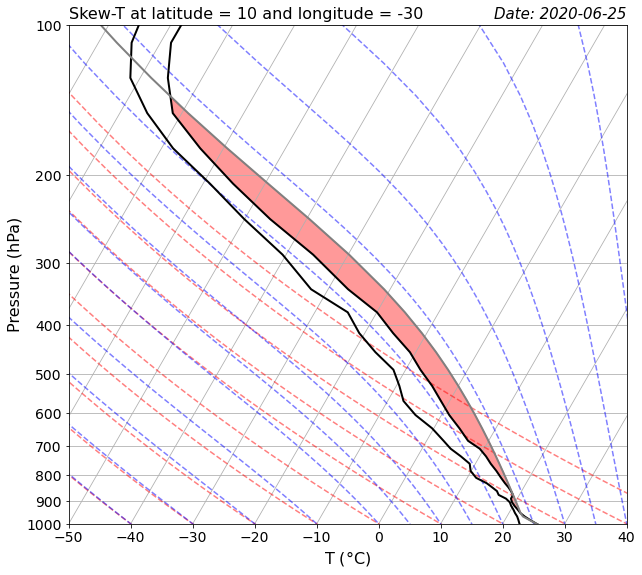


Skew-T for high DUMR:


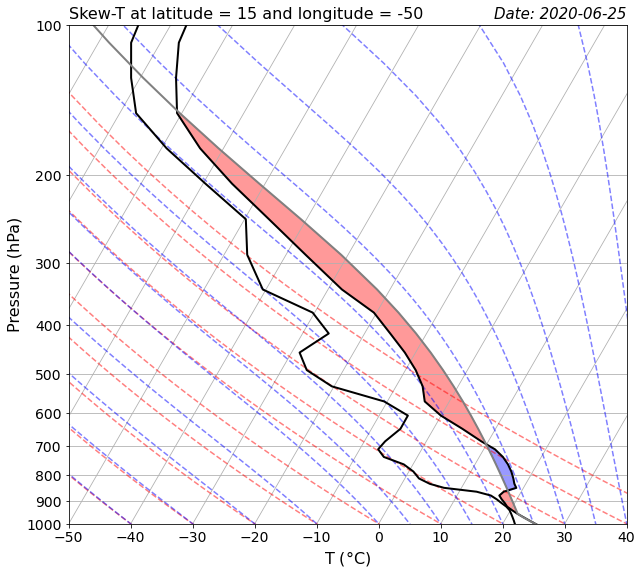

In [14]:
# Plot Skew-Ts
print('Skew-T for low DUMR:')
plot_skew_t(10,-30)
print('\nSkew-T for high DUMR:')
plot_skew_t(15,-50)

These results are only for two specific locations, but if you try changing the latitudes and longitudes to different locations, you will notice that these plots are quite representative of the low and high dust scenarios. Originally, I was expecting to see a lot more CAPE (shaded in red) in the low dust regions, since there would be a lot more moisture in the atmosphere. However, the values of CAPE seem pretty simliar across regions with different dust concentrations. This might be indicative of an overall drying effect of the dust storm over the entire region. An interesting thing to look into for comparison would be values of CAPE for a time where a dust storm was not present in the Atlantic. We see on the other hand that there is more CIN (shaded in blue) in regions with high dust concentration. You can see that the temperature increases by several degrees Celcius on the second Skew-T (high DUMR) between 700hPa and 850hPa, enabling the presence of CIN. This is likely caused by the heating effect of aerosols on the atmosphere due to absorption of radiation.

#### Conclusion

While the data analyzed gave us lots of information at many different locations, this analysis gave us an overview of the effects of a Saharan dust storm on the thermodynamics of the atmosphere. We were able to see the distribution of dust in the atmosphere as well as the way it was transported by wind across the Atlantic. We also saw how DUMR had a strong correlation to reduced levels of relative humidity in the atmosphere, and how the presence of dust in the atmosphere lead to increased values of CIN. To further understand the impact of this event on the atmosphere, future work would involve using this data to run a radiative transfer model to characterize the impacts of such an event on radiative heating in the atmosphere.